In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.models.detection import fcos
from torchvision.transforms import v2 as v2
from tqdm.auto import tqdm, trange

import bb
import models
import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

SEED = 325
tt.seed(SEED)

In [ ]:
data_path = Path.home() / "src/data"
mc_data_path = data_path / "minecraft/info.json"
dset = bb.Dataset.load(mc_data_path)
torch_root = data_path / "torchvision"
ckpt_root = data_path / "checkpoints"

# MCDataset

In [ ]:
BATCH_SIZE = 16
TRAIN_PCT = .85

ckpt_file = str(ckpt_root / "checkpoint.pt")
mcd_root = data_path / "coco/minecraft"
mcd = bb.MCDataset(mcd_root)
train_dset, valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
# bb.plot_bb_grid(images, targets, mcd.categories)

train_loader = DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
valid_loader = DataLoader(
    valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(train_dset)}, n_valid={len(valid_dset)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62


# Fine Tune

In [ ]:
# Test checkpoint
t0 = models.FCOSTrainer(categories=mcd.categories)
t0.save_checkpoint(ckpt_root / "t0.ckpt")
t1 = models.FCOSTrainer(categories=mcd.categories, checkpoint=ckpt_root / "t0.ckpt")
models.compare_models(t0.model, t1.model)

Initializing new model
err_keys = <All keys matched successfully>
Loading checkpoint: /Users/joe/src/data/checkpoints/t0.ckpt
err_keys = <All keys matched successfully>


True

## Compare Inits

In [ ]:
# t_fcos_init = models.FCOSTrainer(categories=mcd.categories, he_init=False)
# t_he_init = models.FCOSTrainer(categories=mcd.categories, he_init=True)
t_fcos_init = models.FCOSTrainer(categories=mcd.categories, he_init=False, checkpoint=ckpt_root / "fcos_init.pt")
t_he_init = models.FCOSTrainer(categories=mcd.categories, he_init=True, checkpoint=ckpt_root / "he_init.pt")

Loading checkpoint: /Users/joe/src/data/checkpoints/fcos_init.pt
err_keys = <All keys matched successfully>
Loading checkpoint: /Users/joe/src/data/checkpoints/he_init.pt
err_keys = <All keys matched successfully>


In [ ]:
t_fcos_init.save_checkpoint(ckpt_root / "fcos_init.pt")
t_he_init.save_checkpoint(ckpt_root / "he_init.pt")

## Scratch

In [ ]:
he_eval = t_he_init.evaluate(valid_loader)
fcos_eval = t_fcos_init.evaluate(valid_loader)

In [ ]:
import pprint

pprint.pprint(he_eval["metric"].compute())
pprint.pprint(fcos_eval["metric"].compute())

{'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32),
 'map': tensor(0.0002),
 'map_50': tensor(0.0008),
 'map_75': tensor(0.),
 'map_large': tensor(0.0006),
 'map_medium': tensor(0.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.),
 'mar_1': tensor(0.0025),
 'mar_10': tensor(0.0150),
 'mar_100': tensor(0.0209),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0269),
 'mar_medium': tensor(0.),
 'mar_small': tensor(0.)}
{'classes': tensor([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32),
 'map': tensor(0.0444),
 'map_50': tensor(0.0676),
 'map_75': tensor(0.0457),
 'map_large': tensor(0.0548),
 'map_medium': tensor(0.0644),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.),
 'mar_1': tensor(0.1341),
 'mar_10': tensor(0.2859),
 'mar_100': tensor(0.2985),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.3619),
 'mar_medium': tensor(0.1086),
 'mar_small': tensor(0.)}


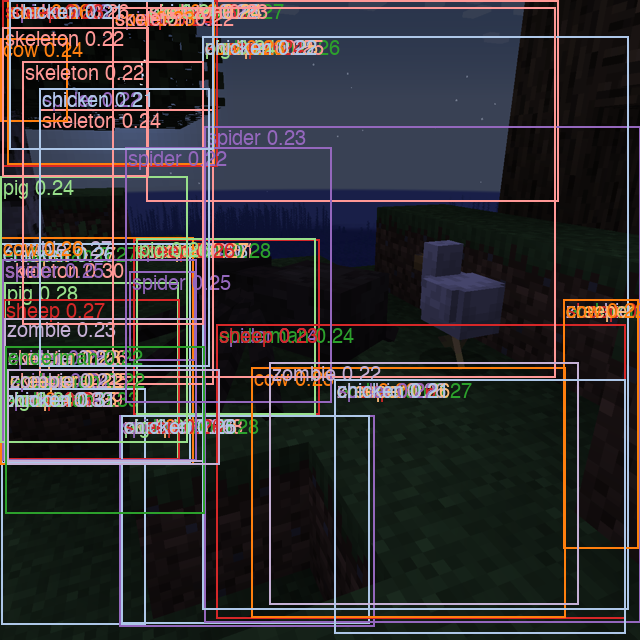

In [ ]:
img_ix = 20
t_fcos_init.plot_infer(mcd[img_ix][0])

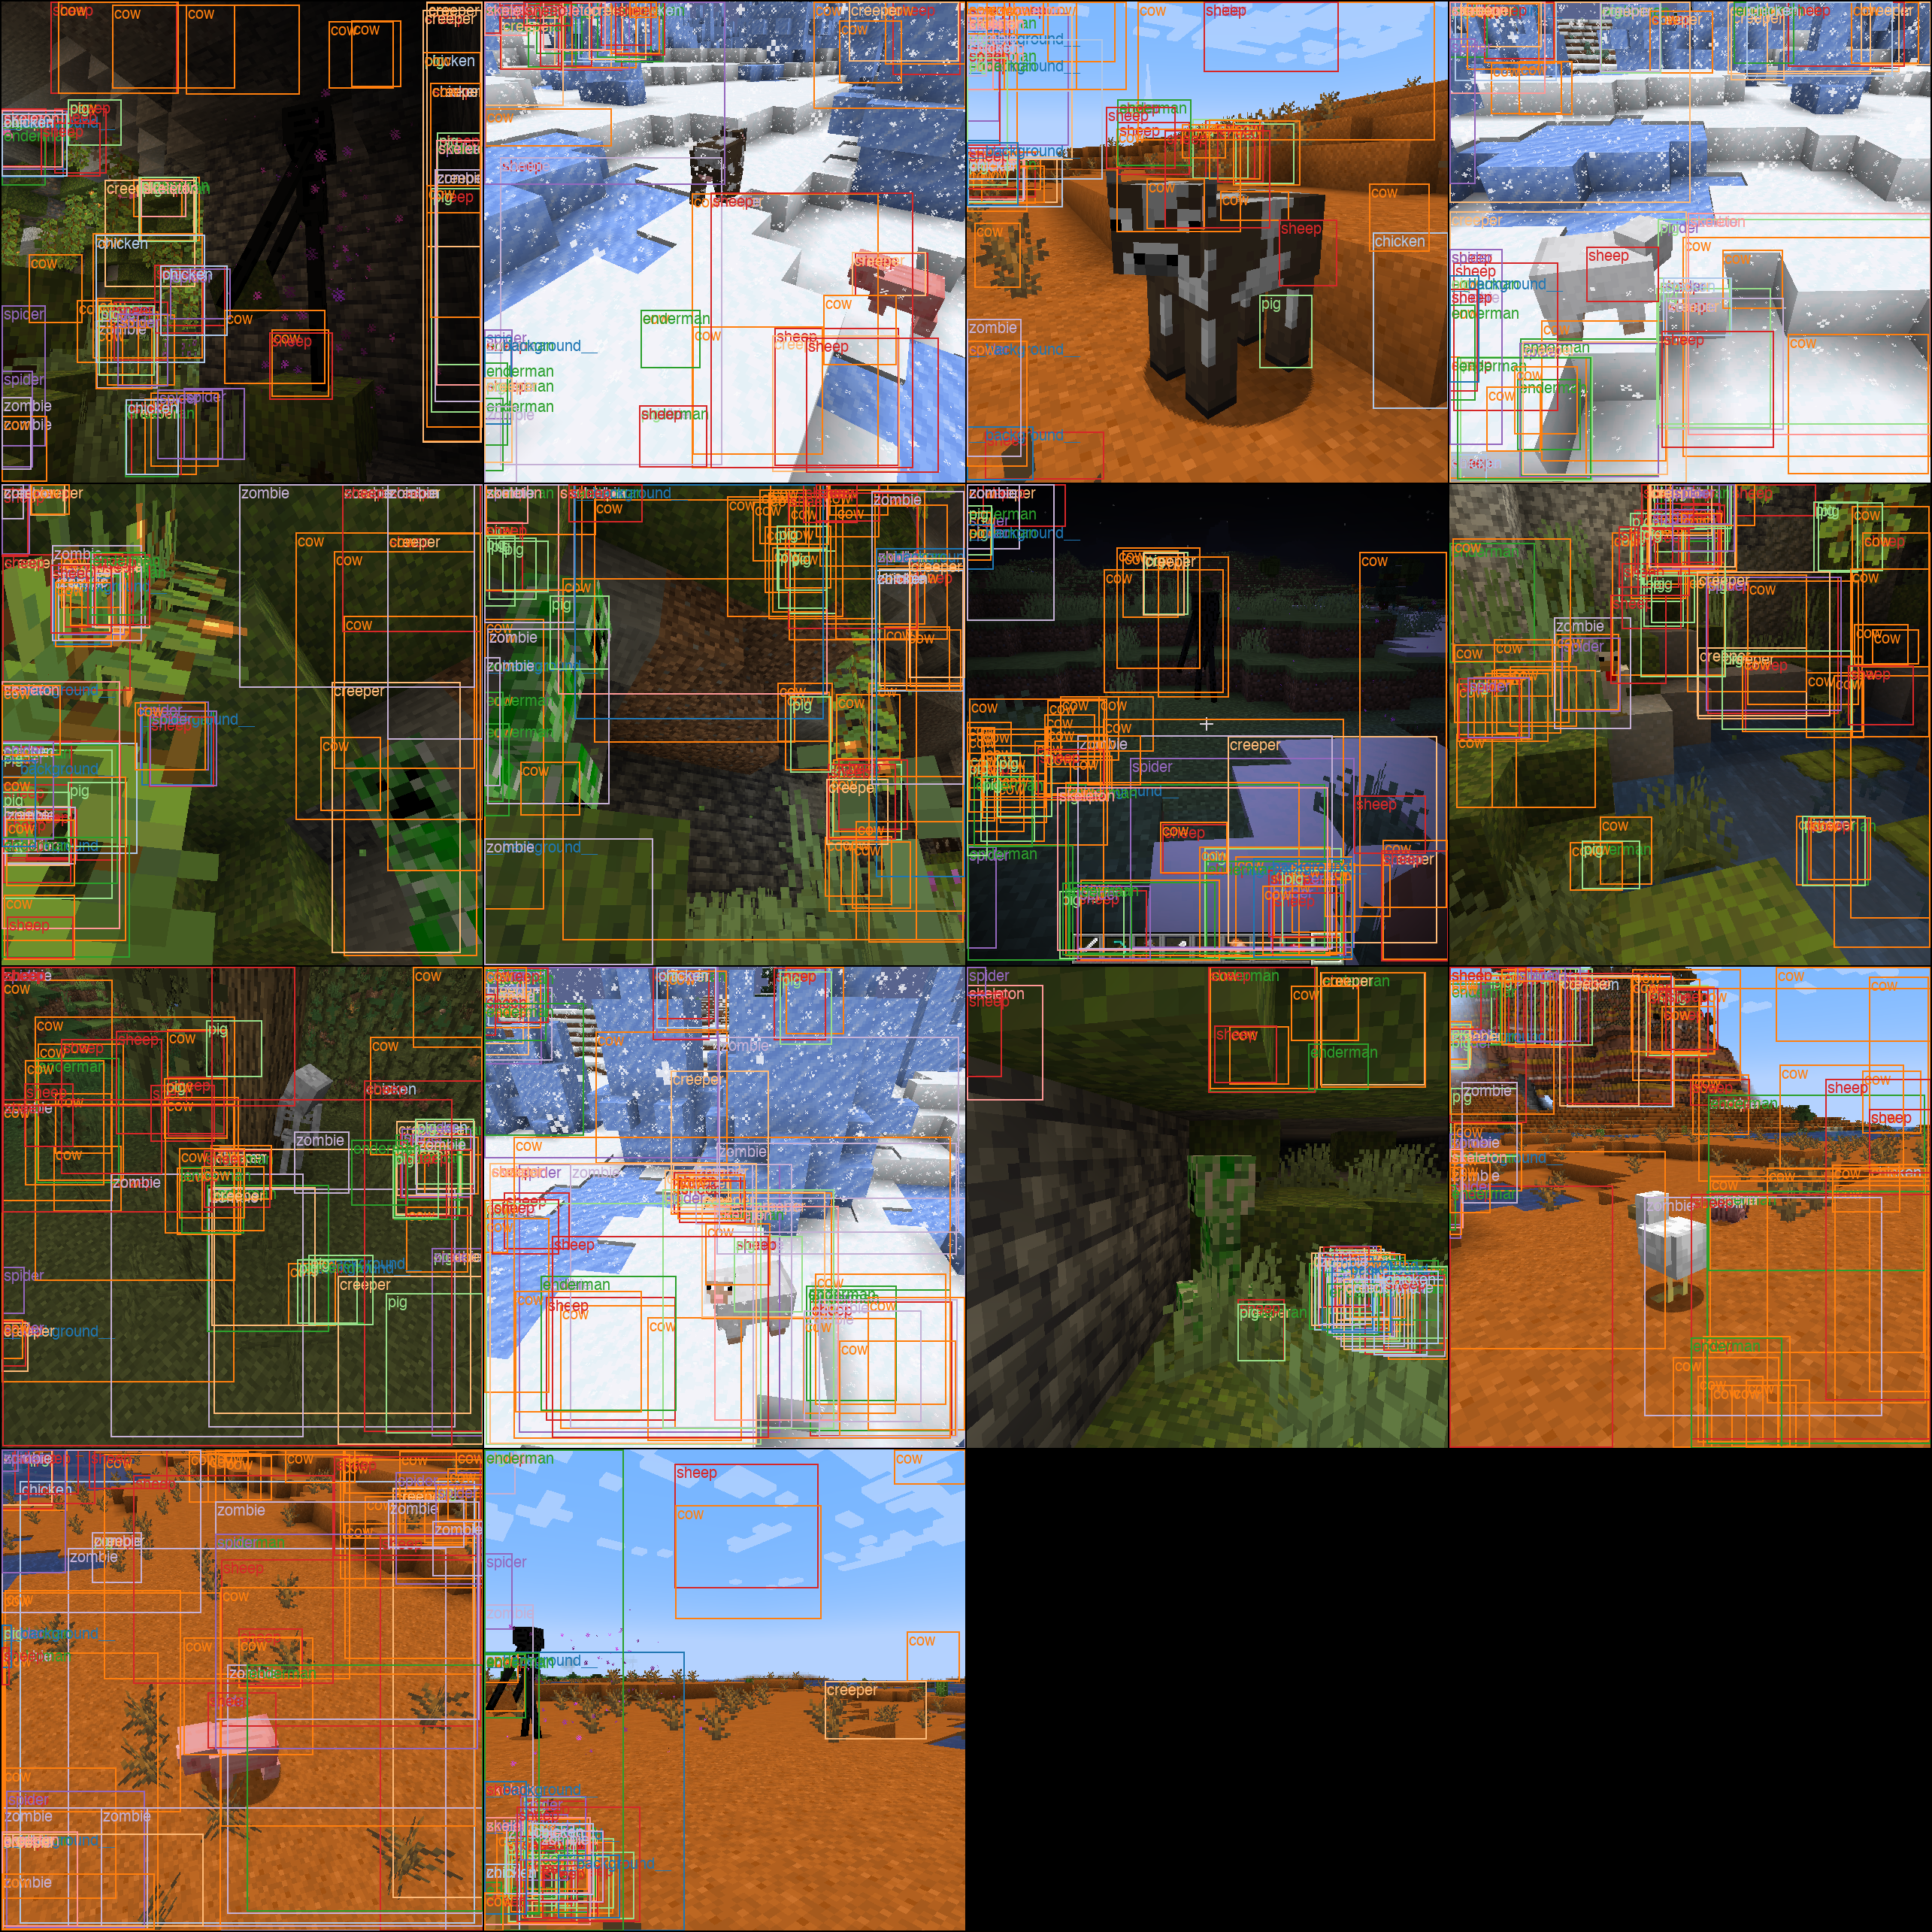

In [ ]:
bb.plot_bb_grid(he_eval["images"], he_eval["preds"], mcd.categories)

## Main

In [ ]:
img_ix = 20
t_fcos_init.infer(mcd[img_ix][0])

{'boxes': tensor([], device='mps:0', size=(0, 4)),
 'scores': tensor([], device='mps:0'),
 'labels': tensor([], device='mps:0', dtype=torch.int64)}

In [ ]:
images, targets = next(iter(train_loader))
bb.plot_bb_grid(images, targets, mcd.categories)

In [ ]:
images, targets = next(iter(train_loader))
preds = t20.forward(images, 0.2)
bb.plot_bb_grid(images, preds, mcd.categories, include_scores=True, nrow=2)